In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import json
import re
import json
import glob
import datetime
from collections import Counter
import statistics
from datetime import datetime
import math
import scipy
import scipy.stats
import panel as pn
pn.extension()
from vega_datasets import data as vds

In [69]:
# Gerando os URL dos .csv
caminho = r'dados_aux/dados-sp-'
todos_dados_csv = glob.glob(caminho + "*.csv")

# Colunas que incluem datas
datas = ['dataNotificacao', 'dataInicioSintomas', 'dataTeste', 'dataEncerramento']

# Colunas a serem lidas
cols = ["dataNotificacao", "dataInicioSintomas", "sintomas", "profissionalSaude", "cbo","condicoes",
        "dataTeste", "tipoTeste", "resultadoTeste", "sexo", "municipio", "municipioIBGE", "estadoNotificacao",
        "estadoNotificacaoIBGE", "idade", "dataEncerramento", "evolucaoCaso", "classificacaoFinal"]

# Carregando os dados
dados = pd.concat((pd.read_csv(f, sep=';', encoding='latin1', parse_dates=datas, usecols=cols, infer_datetime_format = False) for f in todos_dados_csv), ignore_index = True)

In [71]:
# Exclui as linhas cujas colunas indicadas abaixo sao null
dados.dropna(subset = ["dataNotificacao","dataTeste","tipoTeste", "resultadoTeste", "classificacaoFinal", "idade"], inplace = True)

# Exclui os dados Cancelados
dados.drop(dados[dados['evolucaoCaso'] == 'Cancelado'].index, inplace = True)

# Exclui os dados que possuem datas fora do escopo esperado
data_limite_inferior = np.datetime64('2020-01-01', 'ns') # Comeco da pandemia
data_limite_superior = np.datetime64('2021-03-25', 'ns') # A publicacao dos dados mais recentes ocorreram nesse dia
for data in datas:
    dados[data] = pd.to_datetime(dados[data], utc=True).dt.tz_localize(None) # Retira o fuso horario
    dados.drop(dados[(dados[data] < data_limite_inferior) | (dados[data] > data_limite_superior)].index, inplace = True) # Exclui

dados[dados['idade'] > 116] = float("NaN") # Exclui idades invalidas
dados.reset_index(drop=True, inplace = True) # Realoca os indices depois das exclusoes

In [72]:
cidades = {}
for i in range(len(dados)):
    cidadeIBGE = dados['municipioIBGE'][i]
    if cidadeIBGE != cidadeIBGE: # Precisa disso pra pular os dados cujo campo municipioIBGE é NULL (float vira NaN)
        continue
    cidadeIBGE = int(cidadeIBGE)
    resultadoTeste = dados['resultadoTeste'][i]
    if cidadeIBGE not in cidades:
        cidades[cidadeIBGE] = {}
        cidades[cidadeIBGE]['Nome'] = dados['municipio'][i]
        cidades[cidadeIBGE]['Positivo'] = 0
        cidades[cidadeIBGE]['Negativo'] = 0
        cidades[cidadeIBGE]['Inconclusivo ou Indeterminado'] = 0

    # Precisa disso por causa dos NaN
    if resultadoTeste not in cidades[cidadeIBGE]:
        cidades[cidadeIBGE][resultadoTeste] = 0
    cidades[cidadeIBGE][resultadoTeste] += 1

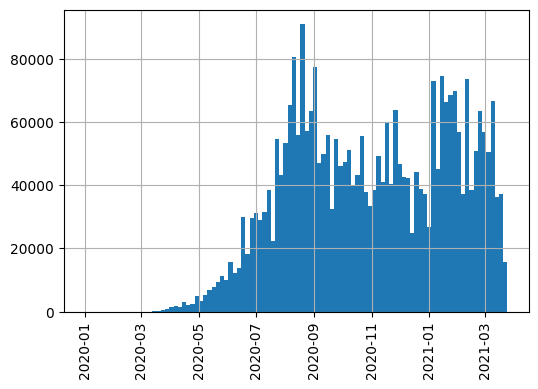

In [73]:
#Criando o histograma do número de casos com resultado e classificação final
dados['dataNotificacao'] = pd.to_datetime(dados['dataNotificacao'])
dados = dados.sort_values('dataNotificacao', ascending=True)
plt.figure(dpi=100)
dados['dataNotificacao'].hist(bins=100)
plt.xticks(rotation='vertical')
plt.show()

40.36198471447034
16.714283021358916
O erro é de : 0.04047831856676525
Dessa forma o intervalo de confiança para idade média é [ 40.321506395903576 ; 40.4024630330371 ]


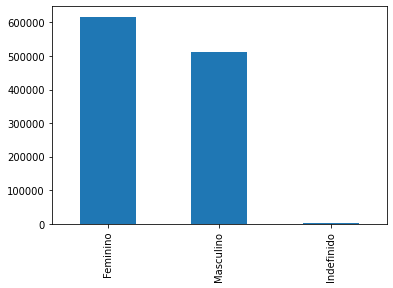

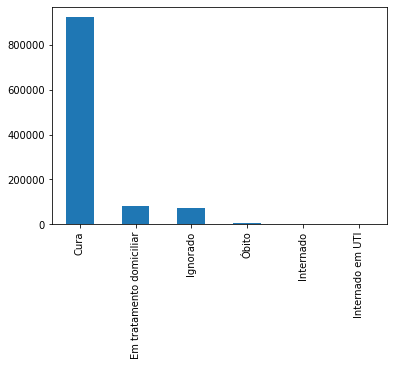

C:\Users\Matheus\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


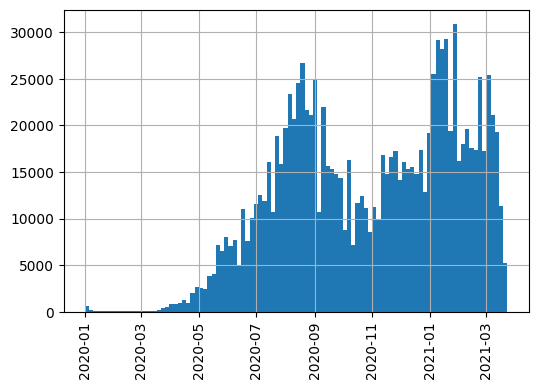

In [74]:
#Media da idade dos casos confirmados para covid

casos_confirmados = dados.query('resultadoTeste == "Positivo" & (classificacaoFinal != "Descartado" & classificacaoFinal != "Síndrome Gripal Não Especificada")')

media_idade_casos_confirmados = np.mean(casos_confirmados['idade'])
desvio_padrao_casos_confirmados = statistics.stdev(casos_confirmados['idade'])
total_dados_casos_confirmados = casos_confirmados.shape[0]
print(media_idade_casos_confirmados)
print(desvio_padrao_casos_confirmados)

# Considerando a distribuição como aproximadamente normal, uma vez que o tamanho amostra é alto, e alpha = 0.01
quantil = abs(scipy.stats.norm.ppf(0.005))
erro_casos_confirmados = quantil * desvio_padrao_casos_confirmados/math.sqrt(total_dados_casos_confirmados)
print("O erro é de :", erro_casos_confirmados)
print("Dessa forma o intervalo de confiança para idade média é [",media_idade_casos_confirmados - erro_casos_confirmados,";",media_idade_casos_confirmados + erro_casos_confirmados,"]")

#Valor analisar a relação de infectados pelo parâmetro "sexo"

casos_confirmados['sexo'].value_counts().plot(kind='bar')
plt.show() 

casos_confirmados['evolucaoCaso'].value_counts().plot(kind='bar')
plt.show() 

#Histograma dos casos confirmados conforme o tempo
casos_confirmados['dataTeste'] = pd.to_datetime(casos_confirmados['dataTeste'])
casos_confirmados = casos_confirmados.sort_values('dataTeste', ascending=True)
plt.figure(dpi=100)
casos_confirmados['dataTeste'].hist(bins=100)
plt.xticks(rotation='vertical')
plt.show()


62.77750518965843
19.34440141498122
O erro é de : 0.6845030939165065
Dessa forma o intervalo de confiança para idade média é [ 62.09300209574192 ; 63.46200828357493 ]


C:\Users\Matheus\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


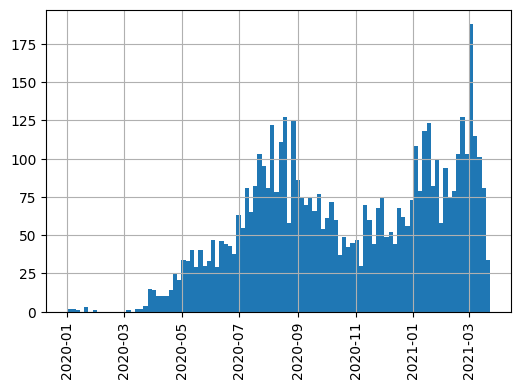

In [75]:
#Media da idade dos casos de óbito por covid

obitos = dados.query('evolucaoCaso == "Óbito"')

media_idade_obitos = np.mean(obitos['idade'])
desvio_padrao_obitos = statistics.stdev(obitos['idade'])
total_dados_obitos = obitos.shape[0]
print(media_idade_obitos)
print(desvio_padrao_obitos)

# Considerando a distribuição como aproximadamente normal, uma vez que o tamanho amostra é alto, e alpha = 0.01
quantil = abs(scipy.stats.norm.ppf(0.005))
erro_obitos= quantil * desvio_padrao_obitos/math.sqrt(total_dados_obitos)
print("O erro é de :", erro_obitos)
print("Dessa forma o intervalo de confiança para idade média é [",media_idade_obitos - erro_obitos,";",media_idade_obitos + erro_obitos,"]")

obitos['dataTeste'] = pd.to_datetime(obitos['dataTeste'])
obitos = obitos.sort_values('dataTeste', ascending=True)
plt.figure(dpi=100)
obitos['dataTeste'].hist(bins=100)
plt.xticks(rotation='vertical')
plt.show()
